
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
scaler = MinMaxScaler().fit(X_train)
X_train, X_test = [pd.DataFrame(scaler.transform(X), columns = X.columns) for X in (X_train, X_test)]
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.551880,0.631528,0.482168,0.438776,0.618723,0.403753,0.591583,0.544518,0.621268,0.503159,0.592887,0.429101,...,0.537128,0.477589,0.558309,0.486270,0.485819,0.391604,0.590949,0.503939,0.370512,0.498539,0.537380,0.461455
std,0.120852,0.127453,0.149090,0.140154,0.141699,0.153665,0.155006,0.164288,0.128469,0.141734,0.160189,0.153374,...,0.177113,0.147707,0.139064,0.149080,0.164067,0.100772,0.164910,0.138239,0.138930,0.161129,0.154759,0.153690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476264,0.557454,0.394956,0.352879,0.529837,0.308342,0.500545,0.429288,0.551025,0.418475,0.507330,0.332571,...,0.425708,0.383596,0.479238,0.388388,0.385852,0.334709,0.506111,0.410831,0.280240,0.405717,0.445447,0.356357
50%,0.559477,0.641672,0.478321,0.437090,0.631015,0.387398,0.587109,0.557519,0.632589,0.504952,0.611899,0.440909,...,0.524862,0.475118,0.551141,0.478502,0.492022,0.384691,0.614133,0.492102,0.358113,0.496963,0.521019,0.459238
75%,0.630576,0.712756,0.554837,0.522697,0.709618,0.493697,0.692712,0.659477,0.706408,0.578614,0.696565,0.535167,...,0.657066,0.570208,0.643646,0.590640,0.584703,0.442659,0.698660,0.583209,0.442772,0.600409,0.633784,0.556818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [5]:
log_unreg = LogisticRegression(C=100000, solver='lbfgs', max_iter=1000).fit(X_train, y_train)

In [6]:
log_unreg_train, log_unreg_test = log_unreg.predict(X_train), log_unreg.predict(X_test)
print('Misclassification on train: %.2f' % (1-accuracy_score(log_unreg_train, y_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(log_unreg_test, y_test)))

Misclassification on train: 0.00
Misclassification on test: 0.23


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [7]:
log_reg = LogisticRegressionCV(cv=5, solver='liblinear', max_iter=1000, penalty='l1').fit(X_train, y_train)

In [8]:
log_reg_train, log_reg_test = log_reg.predict(X_train), log_reg.predict(X_test)
print('Misclassification on train: %.2f' % (1-accuracy_score(log_reg_train, y_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(log_reg_test, y_test)))

Misclassification on train: 0.09
Misclassification on test: 0.14


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [9]:
ks = [1,2,3,4,5,7,9,10,15,25]
classifiers = [KNeighborsClassifier(n_neighbors=ki).fit(X_train, y_train) for ki in ks]

In [10]:
scores = [cross_val_score(cl, X_train, y_train, cv=5) for cl in classifiers]

In [11]:
best_i = np.argmax([np.mean(arr) for arr in scores])
best_knn = classifiers[best_i]
best_knn_train, best_knn_test = best_knn.predict(X_train), best_knn.predict(X_test)
print('Best k is %d' % ks[best_i])
print('Misclassification on train: %.2f' % (1-accuracy_score(best_knn_train, y_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(best_knn_test, y_test)))

Best k is 7
Misclassification on train: 0.10
Misclassification on test: 0.14


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [12]:
def confusion_matrix(y_true, y_pred):
    tp = sum((y_true == 1.0) & (y_pred == 1.0))
    fn = sum((y_true == 1.0) & (y_pred == 0.0))
    tn = sum((y_true == 0.0) & (y_pred == 0.0))
    fp = sum((y_true == 0.0) & (y_pred == 1.0))
    return np.array([[tp, fn], [fp, tn]])

predictions = {
    'Logistic Regression (unregularized)': log_unreg_test,
    'Logistic Regression (regularized)': log_reg_test,
    'KNN': best_knn_test
}
i = 1
for p in predictions.keys():
    print('\n\n', p)
    cm = confusion_matrix(y_test, predictions[p])
    print('\t\tPredicted = 1.0\t\tPredicted = 0.0')
    print('Actual = 1.0      %d (TP)\t\t     %d (FN)' % tuple(cm[0]))
    print('Actual = 0.0      %d (FP)\t\t     %d (TN)' % tuple(cm[1]))



 Logistic Regression (unregularized)
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      52 (TP)		     22 (FN)
Actual = 0.0      13 (FP)		     64 (TN)


 Logistic Regression (regularized)
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      63 (TP)		     11 (FN)
Actual = 0.0      10 (FP)		     67 (TN)


 KNN
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      63 (TP)		     11 (FN)
Actual = 0.0      10 (FP)		     67 (TN)


False positives are similar for all three, but regularized logistic regression performs much better on false negatives than unregularized, reducing them by half - perhaps because regularization avoids some of the spurious predictors. KNN performs similarly with a judicious choice of $k$.

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [13]:
pca = PCA(n_components = len(X_train)).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(601, 601)
(151, 601)


The limiting factor is the smaller of $n$ and $p$, with $n$ being the number of records and $p$ the number of predictors. In this case, we can have at most 601 PCA components.

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

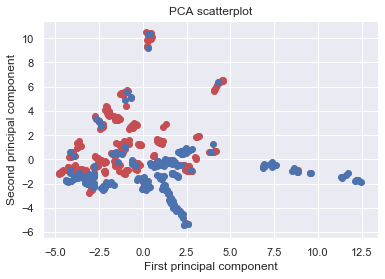

In [14]:
colors = ['r', 'b']
for cl in [0, 1]:
    X_data = X_train_pca[y_train == float(cl)]
    plt.scatter(X_data[:, 0], X_data[:, 1], c=colors[cl])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA scatterplot')
plt.show()

The scatterplot of the top 2 vectors shows the orthogonal transformation that explains the greatest amount of the variance. When PCA is effective, we should see a clear "axis" for each of the classes, introducing a visual differentiation that would have been extremely difficult to see from glancing at the data, projecting the raw features into 2D, or reducing dimensionality at random. The highly differentiated classes above shows that there is a clear distinction along the first two principal components, which we can augment with further components to create an efficient decision boundary.

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

Fraction of variance explained by top 2 vectors: 11.3%
To explain 90%: 231
To explain 95%: 325


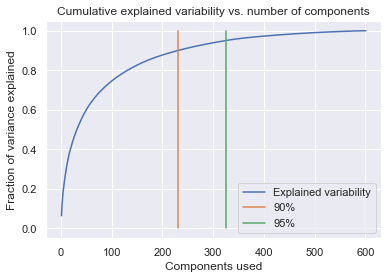

In [15]:
var_mat = np.var(X_train_pca, axis=0)
var_mat /= sum(var_mat)
print('Fraction of variance explained by top 2 vectors: %.1f%%' % (100*sum(var_mat[:2])))
xs, ys = [], []
critical_i_90 = 0
critical_i_95 = 0
total_var = 0
for i, v in enumerate(var_mat, 1):
    total_var += v
    xs.append(i)
    ys.append(total_var)
    if total_var > .9 and critical_i_90 == 0:
        critical_i_90 = i
    if total_var > .95 and critical_i_95 == 0:
        critical_i_95 = i
print('To explain 90%%: %d' % critical_i_90)
print('To explain 95%%: %d' % critical_i_95)
plt.plot(xs, ys)
plt.plot([critical_i_90, critical_i_90], [0.0, 1.0])
plt.plot([critical_i_95, critical_i_95], [0.0, 1.0])
plt.xlabel('Components used')
plt.ylabel('Fraction of variance explained')
plt.title('Cumulative explained variability vs. number of components')
plt.legend(['Explained variability', '90%', '95%'])
plt.show()

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

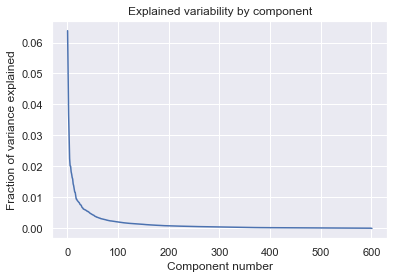

In [16]:
xs, ys = [], []
total_var = 0
for i, v in enumerate(var_mat, 1):
    xs.append(i)
    ys.append(v)
plt.plot(xs, ys)
plt.xlabel('Component number')
plt.ylabel('Fraction of variance explained')
plt.title('Explained variability by component')
plt.show()

Trying to explain 90% of the variance seems agressive based on this graph, where the knee of the curve is around 30 components and the individual contribution is negligible after 100 or so. We could also see how many predictors hold up as significant in a bootstrapping test. As a first approximation, we can choose 80 as the number of PCA predictors, which strikes a balance between explaining variability (about 70%) and setting a reasonable cutoff for the marginal contribution (about 0.3%).

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [17]:
train_data = {
    'PCA2': X_train_pca[:, :2],
    'PCA80': X_train_pca[:, :80],    
    'PCA90v': X_train_pca[:, :231],
}
test_data = {
    'PCA2': X_test_pca[:, :2],
    'PCA80': X_test_pca[:, :80],
    'PCA90v': X_test_pca[:, :231],
}

def get_log_unreg():
    return LogisticRegression(C=100000, solver='lbfgs', max_iter=10000)

models = dict((k, get_log_unreg().fit(train_data[k], y_train)) for k in train_data)

In [18]:
train_predictions = dict((k, models[k].predict(train_data[k])) for k in train_data)
test_predictions = dict((k, models[k].predict(test_data[k])) for k in test_data)
for p in test_predictions.keys():
    print('\n\n%s\n' % p)
    print('Misclassification on train: %.2f' % (1-accuracy_score(train_predictions[p], y_train)))
    print('Misclassification on test: %.2f' % (1-accuracy_score(test_predictions[p], y_test)))
    cm = confusion_matrix(y_test, test_predictions[p])
    print('\t\tPredicted = 1.0\t\tPredicted = 0.0')
    print('Actual = 1.0      %d (TP)\t\t     %d (FN)' % tuple(cm[0]))
    print('Actual = 0.0      %d (FP)\t\t     %d (TN)' % tuple(cm[1]))



PCA2

Misclassification on train: 0.24
Misclassification on test: 0.23
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      58 (TP)		     16 (FN)
Actual = 0.0      19 (FP)		     58 (TN)


PCA80

Misclassification on train: 0.10
Misclassification on test: 0.14
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      63 (TP)		     11 (FN)
Actual = 0.0      10 (FP)		     67 (TN)


PCA90v

Misclassification on train: 0.00
Misclassification on test: 0.25
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      54 (TP)		     20 (FN)
Actual = 0.0      18 (FP)		     59 (TN)


Using only 2 components or as many as 231 (to explain 90% of the variance) leads to a significant degradation in performance, with misclassifications in about a quarter of cases. PCA2 is high-bias, since the train error is also high, while PCA90v is high-variance, classifying all training cases correctly but showing high test error.

80 predictors seems like a decent balance, showing similar performance to the LASSO-regularized logistic regression, which makes sense given that the effect of both adjustments is essentially to drop out less informative predictors.

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [19]:
PCAs = [2, 4, 8, 16, 20, 21, 22, 23, 24, 25, 32, 50, 80, 120, 170, 231, 300]
pca_train_data = dict(('PCA%d' % n, X_train_pca[:, :n]) for n in PCAs)
pca_test_data = dict(('PCA%d' % n, X_test_pca[:, :n]) for n in PCAs)
pca_models = dict((k, get_log_unreg().fit(pca_train_data[k], y_train)) for k in pca_train_data)
for k in pca_models.keys():
    print('Mean CV score for %s: %.4f' % 
          (k, np.mean(cross_val_score(pca_models[k], pca_train_data[k], y_train, cv=5))))

Mean CV score for PCA2: 0.7602
Mean CV score for PCA4: 0.7653
Mean CV score for PCA8: 0.8402
Mean CV score for PCA16: 0.8802
Mean CV score for PCA20: 0.8802
Mean CV score for PCA21: 0.8768
Mean CV score for PCA22: 0.8901
Mean CV score for PCA23: 0.8851
Mean CV score for PCA24: 0.8835
Mean CV score for PCA25: 0.8901
Mean CV score for PCA32: 0.8818
Mean CV score for PCA50: 0.8686
Mean CV score for PCA80: 0.8403
Mean CV score for PCA120: 0.7568
Mean CV score for PCA170: 0.7239
Mean CV score for PCA231: 0.7252
Mean CV score for PCA300: 0.6990


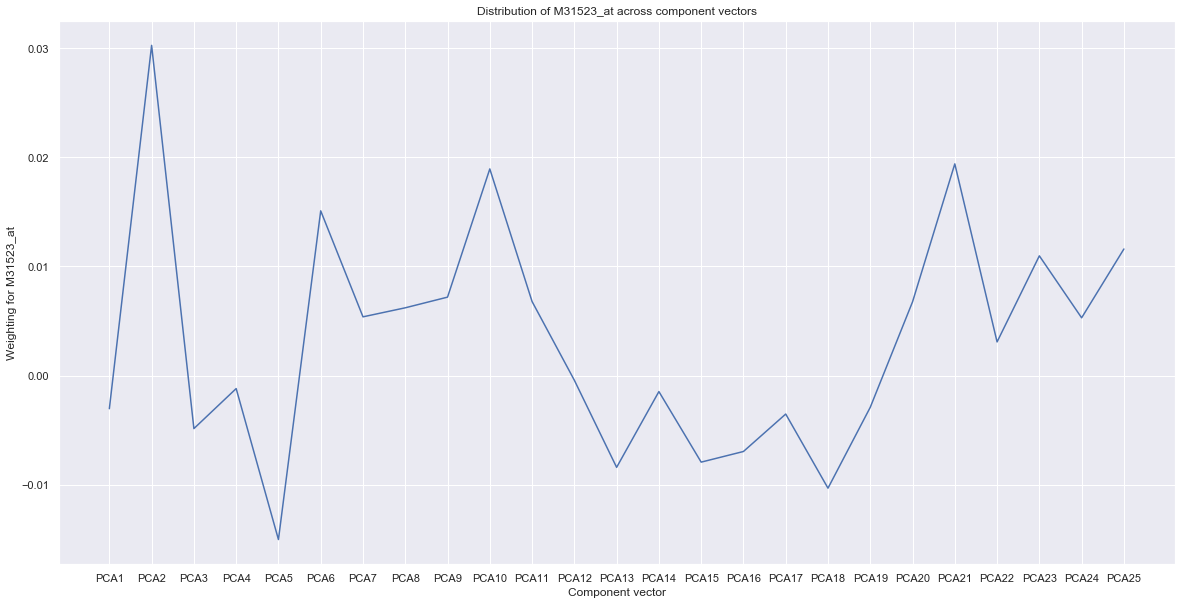

In [20]:
best_pca_trans = PCA(n_components=25).fit(X_train)
coefs = pd.DataFrame(best_pca_trans.components_, columns=X_train.columns)
plt.figure(figsize=(20, 10))
plt.plot(['PCA%d' % (i+1) for i in range(25)], coefs['M31523_at'])
plt.xlabel('Component vector')
plt.ylabel('Weighting for M31523_at')
plt.title('Distribution of M31523_at across component vectors')
plt.show()

We can see that although M31523_at is an important predictor in our logistic regression models, its effect is not highly concentrated in any one component vector. The second principal component vector (PCA2) has the largest weighting at approximately .03, but the effect of M31523_at is not predominant in any of the vectors.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

The ROC (Receiver Operating Characteristic) plots true positives against false positives at different classification thresholds as a way of illustrating the overall performance of the model. The quality is generally indicated by the AUC, in which 1.0 is perfect and 0.5 is random. Although the ROC curve by itself does not show the confusion matrix as clearly as a table might, it is much more powerful in its ability to communicate performance across all thresholds, whereas our approach of looking at misclassification rates only evaluates one threshold.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

AUROC for Logistic (unregularized): 0.845
AUROC for Logistic (regularized): 0.864
AUROC for KNN: 0.860
AUROC for PCA2: 0.821
AUROC for PCA25: 0.845
AUROC for PCA80: 0.865
AUROC for PCA231: 0.795


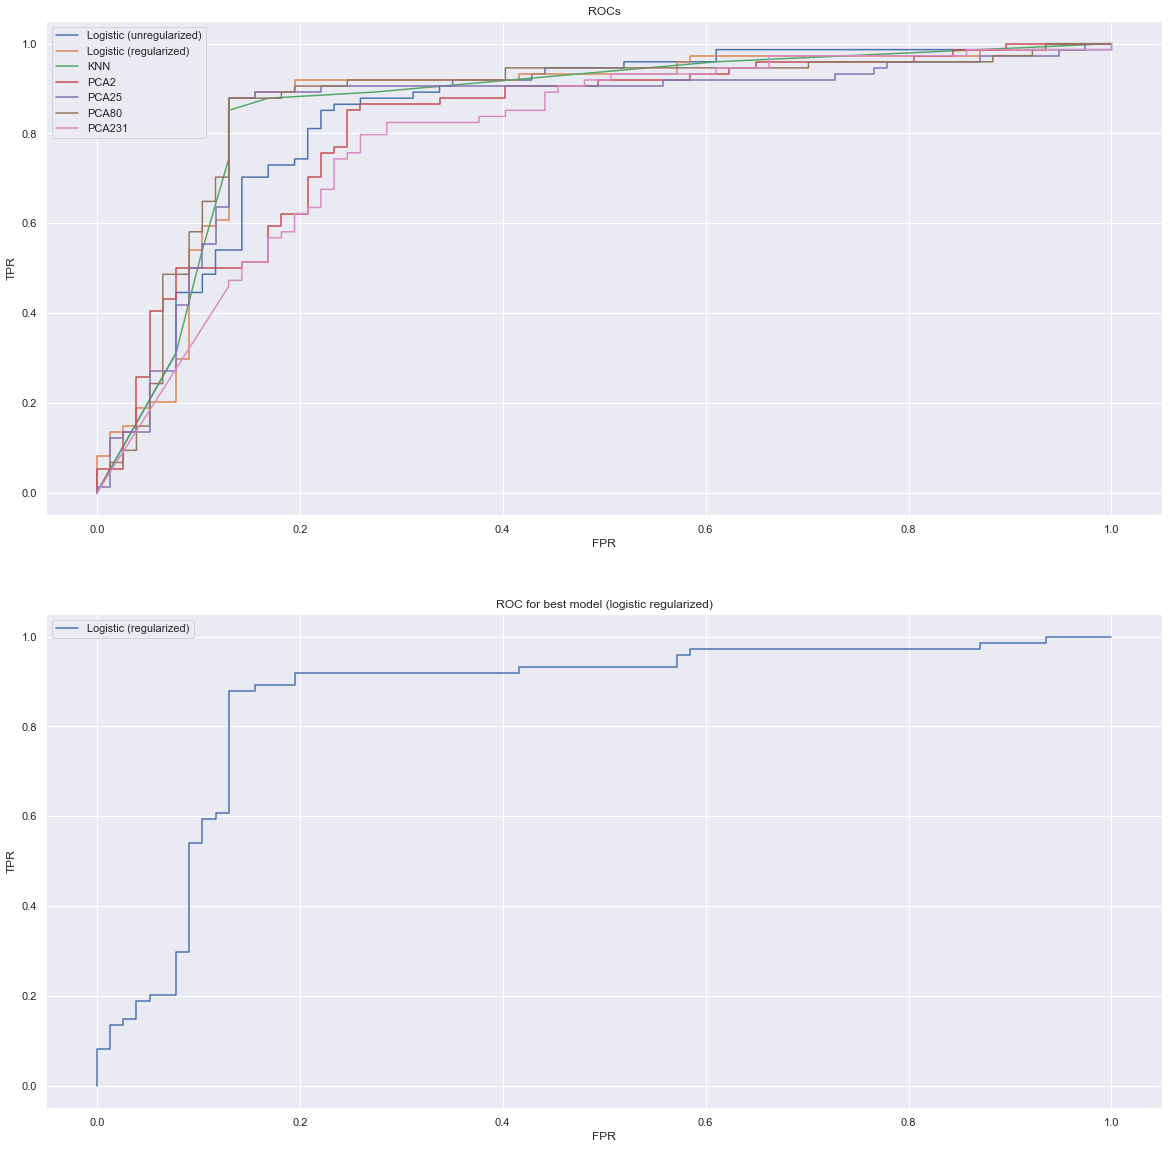

In [21]:
from sklearn.metrics import roc_curve, auc

auc_predictions = {
    'Logistic (unregularized)': log_unreg.predict_proba(X_test),
    'Logistic (regularized)': log_reg.predict_proba(X_test),
    'KNN': best_knn.predict_proba(X_test),
    'PCA2': pca_models['PCA2'].predict_proba(pca_test_data['PCA2']),
    'PCA25': pca_models['PCA25'].predict_proba(pca_test_data['PCA25']),
    'PCA80': pca_models['PCA80'].predict_proba(pca_test_data['PCA80']),
    'PCA231': pca_models['PCA231'].predict_proba(pca_test_data['PCA231'])
}
plt.figure(figsize=(20, 20))

# All
plt.subplot(2, 1, 1)
for k, p in auc_predictions.items():
    fpr, tpr, thresholds = roc_curve(y_test, p[:, 1], drop_intermediate=False)
    plt.plot(fpr, tpr, label=k)
    print('AUROC for %s: %.3f' % (k, auc(fpr, tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROCs')
plt.legend()

# Best
plt.subplot(2,1,2)
fpr, tpr, thresholds = roc_curve(y_test, auc_predictions['Logistic (regularized)'][:, 1], drop_intermediate=False)
plt.plot(fpr, tpr, label='Logistic (regularized)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for best model (logistic regularized)')
plt.legend()
plt.show()

PCA80 edges out regularized logistic by a nose, but for all intents and purposes they perform equally well based on AUC. It seems that both models need about a 14% FPR before they can classify most of the true positives (85-90%) correctly, but on the whole each model strikes a good balance between specificity and sensitivity. Additional changes in threshold do not yield significant gains, as the TPR rises only slightly as the FPR climbs to 1.

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

PCA80 and regularized logistic seem to perform about equivalently, with KNN not too far behind. If we were making predictions for real cancer patients, we would have a range of options at our disposal. If we had a thesis on which model was most theoretically appropriate, we could prioritize that one. For instance, we might believe that there are many genes with minor effect that do not explain a large percentage of the variance but are nonetheless significant predictors, in which case it would be more appropriate to use LASSO-regularized logistic regression. Alternatively, we could be agnostic as to the most effective model, and apply a weighted average of the predictions from our top PCA, logistic, and possibly KNN models.

As in HW4, we could abstain from predicting in cases where confidence fell below a certain threshold.

<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in train and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in train and test later.**

In [22]:
from sklearn.preprocessing import OneHotEncoder
compas_df = pd.read_csv('data/compas.csv')
compas_df = pd.get_dummies(compas_df)
compas_df.describe()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,...,c_charge_desc_arrest case no charge,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,score_text_High,score_text_Low,score_text_Medium,sex_Female,sex_Male
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,...,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,34.534511,3.246436,0.059300,0.091218,0.110661,4.418503,0.455120,15.113091,0.182923,0.237200,0.242061,0.033701,...,0.127025,0.514420,0.005023,0.340732,0.082469,0.001782,0.055574,0.185353,0.554277,0.260369,0.190376,0.809624
std,11.730938,4.743770,0.463599,0.497872,0.470731,2.839463,0.498022,46.679771,0.386635,0.425401,0.428366,0.180472,...,0.333028,0.499833,0.070698,0.473994,0.275101,0.042182,0.229115,0.388615,0.497086,0.438872,0.392629,0.392629
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,31.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,42.000000,4.000000,0.000000,0.000000,0.000000,7.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,96.000000,38.000000,20.000000,13.000000,9.000000,10.000000,1.000000,800.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
compas_df.head(10)

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,...,c_charge_desc_arrest case no charge,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,score_text_High,score_text_Low,score_text_Medium,sex_Female,sex_Male
0,69,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,1
1,34,0,0,0,0,3,1,10,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,1
2,24,4,0,0,1,4,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,0,1
3,44,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,1
4,41,14,0,0,0,6,1,6,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1,0,1
5,43,3,0,0,0,4,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0,0,1
6,39,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0
7,27,0,0,0,0,4,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1
8,23,3,0,0,0,6,1,4,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1,0,1
9,37,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0


In [24]:
CX_train, CX_test, Cy_train, Cy_test = train_test_split(compas_df.loc[:, compas_df.columns != 'two_year_recid'], 
                                                        compas_df.two_year_recid, test_size=0.2, 
                                                        random_state = 109, 
                                                        stratify = compas_df.two_year_recid)
scaler = MinMaxScaler().fit(CX_train)
CX_train, CX_test = [pd.DataFrame(scaler.transform(X), columns = X.columns) for X in (CX_train, CX_test)]
CX_train.describe()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,...,c_charge_desc_arrest case no charge,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,score_text_High,score_text_Low,score_text_Medium,sex_Female,sex_Male
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,...,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,0.203899,0.086500,0.002775,0.007167,0.011973,0.378908,0.019017,0.186551,0.235973,0.242455,0.032813,0.057525,...,0.127608,0.515495,0.004659,0.342313,0.079806,0.001215,0.056512,0.185943,0.556613,0.257444,0.190196,0.809804
std,0.153375,0.126607,0.022982,0.039615,0.050178,0.317013,0.058048,0.389590,0.424649,0.428611,0.178166,0.232866,...,0.333686,0.499810,0.068102,0.474532,0.271019,0.034844,0.230931,0.389100,0.496835,0.437270,0.392496,0.392496
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.077922,0.000000,0.000000,0.000000,0.000000,0.111111,0.001250,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.155844,0.026316,0.000000,0.000000,0.000000,0.333333,0.001250,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.298701,0.105263,0.000000,0.000000,0.000000,0.666667,0.007500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

('decile_score', (19.526016387915377, 2.274487521315587e-81))
('age', (-14.170752136319036, 1.431459745073965e-44))
('priors_count', (12.673131045323887, 3.751180773802624e-36))
('priors_5plus', (11.824394261497678, 9.184405961722693e-32))
('c_charge_degree_F', (7.62267255438623, 3.048151223232255e-14))
('c_charge_degree_M', (-7.62267255438623, 3.048151223232255e-14))
('juv_misd_1plus', (7.239374477365959, 5.326816352184346e-13))
('juv_fel_1plus', (6.161610818085111, 7.871421005699623e-10))
('juv_misd_count', (5.734822287419682, 1.0441797484273571e-08))
('length_of_stay', (4.077136813038804, 4.6430946506980446e-05))
('length_of_stay_thresh', (3.857445435817838, 0.00011628226199576945))
('juv_fel_count', (3.7999996648081544, 0.00014672925441644406))
('juv_other_1plus', (3.7378986651762234, 0.00018801434891126662))
('juv_other_count', (2.9972366254609164, 0.0027402103843766033))
('charge_any_theft', (2.582044575281415, 0.009854987152473654))
('charge_any_violence_aggression', (-2.3956982

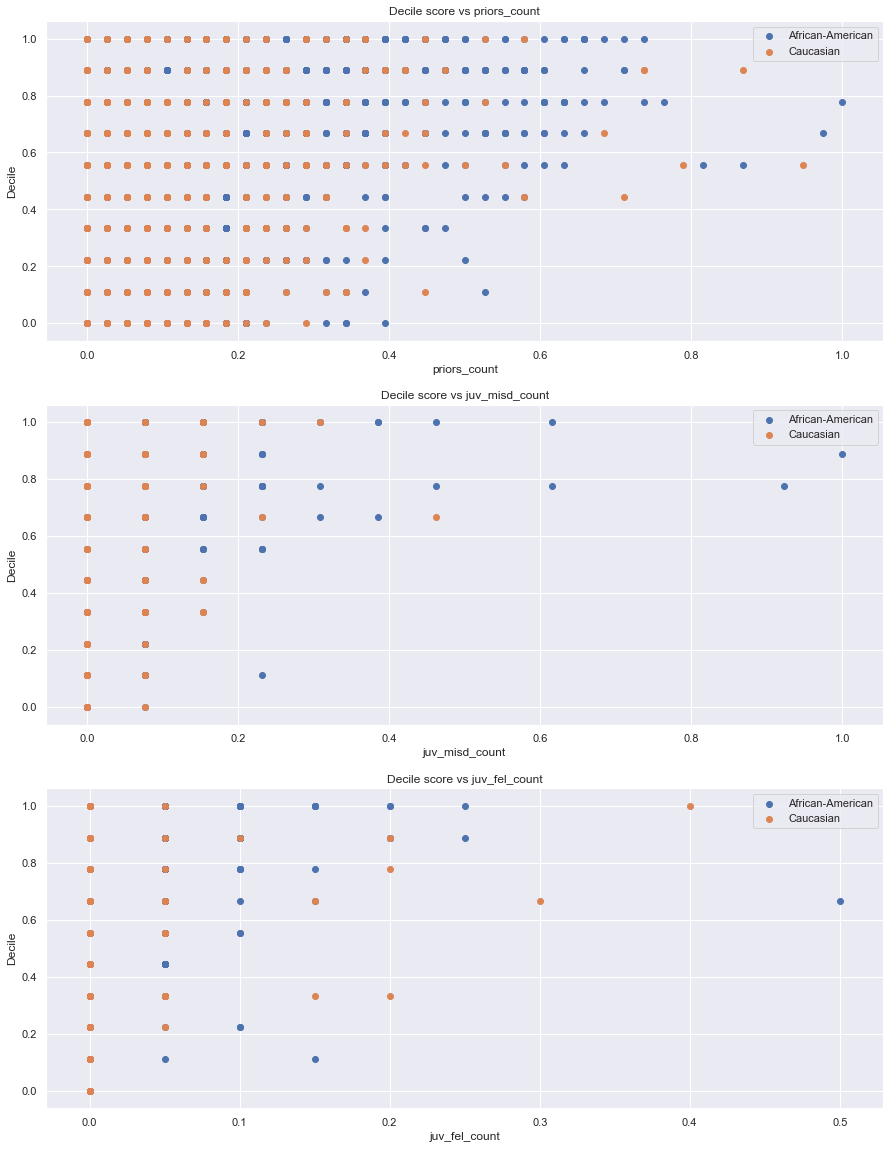

In [25]:
from scipy.stats import ttest_ind
aas, cas = CX_train['race_African-American'], CX_train['race_Caucasian']
tpvals = dict()
for col in CX_train.columns:
    if col.startswith('race'):
        continue
    aa_vals, ca_vals = CX_train[col][aas > 0], CX_train[col][cas > 0]
    t, p = ttest_ind(aa_vals, ca_vals)
    tpvals[col] = (t, p)
print("\n".join(str(x) for x in sorted(tpvals.items(), key = lambda x: x[1][1])[:17]))
chosen_cols = ['priors_count', 'juv_misd_count', 'juv_fel_count']

i = 1
plt.figure(figsize=(15, 20))
for col in chosen_cols:
    plt.subplot(3, 1, i)
    aa_vals, ca_vals = CX_train[aas > 0][col], CX_train[cas > 0][col]
    aa_dec, ca_dec = CX_train[aas > 0]['decile_score'], CX_train[cas > 0]['decile_score']
    plt.scatter(aa_vals, aa_dec, label='African-American')
    plt.scatter(ca_vals, ca_dec, label='Caucasian')
    plt.ylabel('Decile')
    plt.xlabel(col)
    plt.title('Decile score vs %s' % col)
    plt.legend()
    i += 1
plt.show()

**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

We can see in general that African-Americans in the data set have higher average rates of prior offences, juvenile misdemeanors, and felonies. This illustrates a classic problem with self-perpetuating bias:

(1) Past crime frequency and severity do correlate with the risk of recidivism.

(2) However, African-Americans are likely arrested, charged, and convicted at higher rates (as well as sentenced more severely), due not only to differences in the actual crimes committed but also to harsher treatment by the police and the court system.

(3) Therefore, African-Americans who come under consideration tend to have more past offenses on their record. A system trained on this data will naturally start to predict based on data that is highly correlated with race even if race itself is not used.

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [26]:
def print_confusion_matrix(cm, norm=False):
    print('\t\tPredicted = 1.0\t\tPredicted = 0.0')
    if norm:
        cm = cm / sum(sum(cm))
        print('Actual = 1.0      %.2f (TP)\t\t     %.2f (FN)' % tuple(cm[0]))
        print('Actual = 0.0      %.2f (FP)\t\t     %.2f (TN)' % tuple(cm[1]))
    else:
        print('Actual = 1.0      %d (TP)\t\t     %d (FN)' % tuple(cm[0]))
        print('Actual = 0.0      %d (FP)\t\t     %d (TN)' % tuple(cm[1]))

In [27]:
race_cols = list(filter(lambda x: x.startswith('race'), CX_train.columns))
all_cols = [*chosen_cols, *race_cols]
ks = [15,20,25,30]
CX_train_sub, CX_test_sub = CX_train[all_cols], CX_test[all_cols]
knn_classifiers = [KNeighborsClassifier(n_neighbors=ki).fit(CX_train_sub, Cy_train) for ki in ks]
scores = [cross_val_score(cl, CX_train, Cy_train, cv=5) for cl in knn_classifiers]
best_i = np.argmax([np.mean(arr) for arr in scores])
best_knn = knn_classifiers[best_i]
print('Best k is %d' % ks[best_i])
best_knn_train, best_knn_test = best_knn.predict(CX_train_sub), best_knn.predict(CX_test_sub)
print('Misclassification on train: %.2f' % (1-accuracy_score(best_knn_train, Cy_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(best_knn_test, Cy_test)))
print_confusion_matrix(confusion_matrix(Cy_test, best_knn_test))

Best k is 25
Misclassification on train: 0.39
Misclassification on test: 0.40
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      329 (TP)		     233 (FN)
Actual = 0.0      264 (FP)		     409 (TN)


In [28]:
log_reg = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=1000, cv=5).fit(CX_train_sub, Cy_train)
log_reg_train, log_reg_test = log_reg.predict(CX_train_sub), log_reg.predict(CX_test_sub)
print('Misclassification on train: %.2f' % (1-accuracy_score(log_reg_train, Cy_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(log_reg_test, Cy_test)))
print_confusion_matrix(confusion_matrix(Cy_test, log_reg_test))

Misclassification on train: 0.36
Misclassification on test: 0.36
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      224 (TP)		     338 (FN)
Actual = 0.0      104 (FP)		     569 (TN)


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [29]:
CX_train_sub, CX_test_sub = CX_train[chosen_cols], CX_test[chosen_cols]

In [30]:
knn_classifiers = [KNeighborsClassifier(n_neighbors=ki).fit(CX_train_sub, Cy_train) for ki in ks]
scores = [cross_val_score(cl, CX_train, Cy_train, cv=5) for cl in knn_classifiers]
best_i = np.argmax([np.mean(arr) for arr in scores])
best_knn = knn_classifiers[best_i]
print('Best k is %d' % ks[best_i])
best_knn_train, best_knn_test = best_knn.predict(CX_train_sub), best_knn.predict(CX_test_sub)
print('Misclassification on train: %.2f' % (1-accuracy_score(best_knn_train, Cy_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(best_knn_test, Cy_test)))
print_confusion_matrix(confusion_matrix(Cy_test, best_knn_test))

Best k is 25
Misclassification on train: 0.36
Misclassification on test: 0.37
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      272 (TP)		     290 (FN)
Actual = 0.0      170 (FP)		     503 (TN)


In [31]:
log_reg = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=1000, cv=5).fit(CX_train_sub, Cy_train)
log_reg_train, log_reg_test = log_reg.predict(CX_train_sub), log_reg.predict(CX_test_sub)
print('Misclassification on train: %.2f' % (1-accuracy_score(log_reg_train, Cy_train)))
print('Misclassification on test: %.2f' % (1-accuracy_score(log_reg_test, Cy_test)))
print_confusion_matrix(confusion_matrix(Cy_test, log_reg_test))

Misclassification on train: 0.35
Misclassification on test: 0.36
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      221 (TP)		     341 (FN)
Actual = 0.0      102 (FP)		     571 (TN)


In [32]:
aa_test, ca_test = CX_test['race_African-American'], CX_test['race_Caucasian']
Cy_test_aa, Cy_test_ca = np.array(Cy_test)[aa_test > 0], np.array(Cy_test)[ca_test > 0]
knn_test_aa, knn_test_ca = best_knn_test[aa_test > 0], best_knn_test[ca_test > 0]
log_reg_test_aa, log_reg_test_ca = log_reg_test[aa_test > 0], log_reg_test[ca_test > 0]
print('\n\nKNN, African-American')
print_confusion_matrix(confusion_matrix(Cy_test_aa, knn_test_aa), norm=True)
print('\n\nKNN, Caucasian')
print_confusion_matrix(confusion_matrix(Cy_test_ca, knn_test_ca), norm=True)
print('\n\nLogistic Regularized, African-American')
print_confusion_matrix(confusion_matrix(Cy_test_aa, log_reg_test_aa), norm=True)
print('\n\nLogistic Regularized, Caucasian')
print_confusion_matrix(confusion_matrix(Cy_test_ca, log_reg_test_ca), norm=True)



KNN, African-American
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      0.29 (TP)		     0.24 (FN)
Actual = 0.0      0.15 (FP)		     0.32 (TN)


KNN, Caucasian
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      0.16 (TP)		     0.23 (FN)
Actual = 0.0      0.12 (FP)		     0.48 (TN)


Logistic Regularized, African-American
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      0.24 (TP)		     0.28 (FN)
Actual = 0.0      0.11 (FP)		     0.37 (TN)


Logistic Regularized, Caucasian
		Predicted = 1.0		Predicted = 0.0
Actual = 1.0      0.11 (TP)		     0.28 (FN)
Actual = 0.0      0.06 (FP)		     0.54 (TN)


(1) The models, especially the two regularized logistic models, perform similarly with or without race as a predictor, indicating that each non-race-based model is inferring much of the information predicted by race through other columns.

(2) The models perform materially worse for African-Americans than for Caucasians, and the difference is driven by the false positive rate. False negative rates are similar, but the false positive rate is higher for African-Americans in both cases.

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

Garbage in, garbage out; bias in, bias out.

A predictive model can generally be trusted to capture the structure of the data optimally and make good predictions on its training data. If the model is well-designed and sufficiently powerful to generalize, it may also achieve strong results on the test data and explanatory power for new cases. However, no uncorrected model can overcome inherent bias in the generation or collection of the original data: whatever the reason, if race correlates strongly with prior offenses, juvenile misdemeanors, and felony counts, then the model will treat different races differently.

If all participants in the justice system were treated equally in terms of arrest rates, conviction, sentencing, and other factors, and race were still strongly correlated with recidivism, then the issue of using race as a predictor would be morally fraught but more statistically valid. However, as long as there is clear bias in these underlying factors - the way people in the system are treated in the first place - ignoring that bias in our model only serves to confirm and reinforce it.

---